# Bulk Walkthrough

Output directory structure (**TODO**: move to README)

```
bulk_walkthrough_output/
├── checkpoints/
│   ├── checkpoint_241201_143022.pkl
│   └── checkpoint_my_experiment_001.pkl
├── 241201_143022_data/
│   ├── pso_selected_genes.pkl
│   ├── pso_selected_genes.txt
│   ├── pso_final_results.pkl
│   └── ...
└── my_experiment_001_data/
    └── ...
```

Last updated: 26.08.2025

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import pickle
from datetime import datetime

import pandas as pd

import PAGEpy
from PAGEpy import plot_functions, pso, utils
from PAGEpy.dataset_class import GeneExpressionDataset
from PAGEpy.models import AdvancedNN, TrainingConfig

PAGEpy.setup_jupyter_logging(level=logging.INFO)
logger = logging.getLogger("Bulk Walkthrough")

2025-08-26 19:57:07.316110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756238227.330325 1703684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756238227.334685 1703684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Initialize CUDA for GPU support
gpu_available = utils.init_tensorflow()

19:57:24 [utils:25] GPU devices available: 1
19:57:24 [utils:31] CUDA memory allocator configured
19:57:24 [utils:36] Memory growth enabled for 1 GPU(s)
19:57:24 [utils:54] Mixed precision (float16) enabled
19:57:24 [utils:82] XLA compilation enabled


### Configure output filenames

By default the run ID is the current date & time, manually change this to resume a previous run.

In [4]:
run_id = datetime.now().strftime("%y%m%d_%H%M%S")
# run_id = "TEST"

output_dir = "bulk_walkthrough_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

data_directory = os.path.join(output_dir, f"{run_id}_data")
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

## Create Dataset

In [5]:
# TODO: instead of file patterns, use whole filenames
current_data = GeneExpressionDataset(
    data_dir="../../bulk_data/",
    counts_pattern="count_matrix.mtx",
    barcodes_pattern="sample_names.txt",
    # I think here it's possible to set already processed gene list:
    genes_pattern="gene_names.txt",
    metadata_pattern="response_labels.csv",
    gene_selection="Diff",
    pval_cutoff=0.00005,
    pval_correction="benjamini-hochberg",
    features_out_filename=os.path.join(
        data_directory, "feature_set.pkl"),
    train_samples_out_filename=os.path.join(
        data_directory, "train_samples.txt"),
    positive_label="yes"  # TODO: find out how Sean originally encoded it
)

/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
19:57:31 [dataset_class:133] AnnData object constructed with 831 samples and 11528 features (genes).
19:57:31 [dataset_class:140] Counts normalized and log-transformed.
19:57:31 [dataset_class:192] Split data: 664 training samples, 167 test samples.
... storing 'Status' as categorical
... storing 'split' as categorical
/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/numba/cpython/old_hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behav

In [6]:
# Use genes selected during dataset creation...
# genes_path = current_data.selected_features

# ...or load selected genes from .pkl file
genes_path = os.path.join(
    data_directory, "feature_set.pkl")

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)
logger.info(f"Loaded {len(current_genes)} genes as 'current_genes'")

Loaded 1757 genes as 'current_genes'


## Initialize and train NN Model

Set NN model parameters

In [7]:
# retrieved default params used in Sean's code
config = TrainingConfig(
    report_frequency=1,
    auc_threshold=1,
    learning_rate=0.001)

training_params = {
    # 'n_epochs': 50,
    'n_epochs': 500,
    'batch_size': 64,
    'seed': 42,
}

Train NN model before PSO

In [8]:
# Initialize NN model
initial_model = AdvancedNN(
    n_input_features=len(current_genes),
    config=config,
)

# Train model
train_history = initial_model.train(
    x_train=current_data.x_train,
    y_train=current_data.y_train,
    x_test=current_data.x_test,
    y_test=current_data.y_test,
    **training_params,
)

/home/jovyan/.local/share/hatch/env/virtual/pagepy/RRSnIvUW/pagepy/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1756238263.402390 1703684 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1756238263.403956 1703684 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12436 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1756238264.505433 1704561 service.cc:148] XLA service 0x7f3b1400c370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756238264.505453 1704561 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 3g.20gb, Compute Capability 8.0
I0000 00:00:1756238264.597819 1704561 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:175623

19:58:47 [plot_functions:32] Max metrics
	Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.74 | Test AUC: 0.63


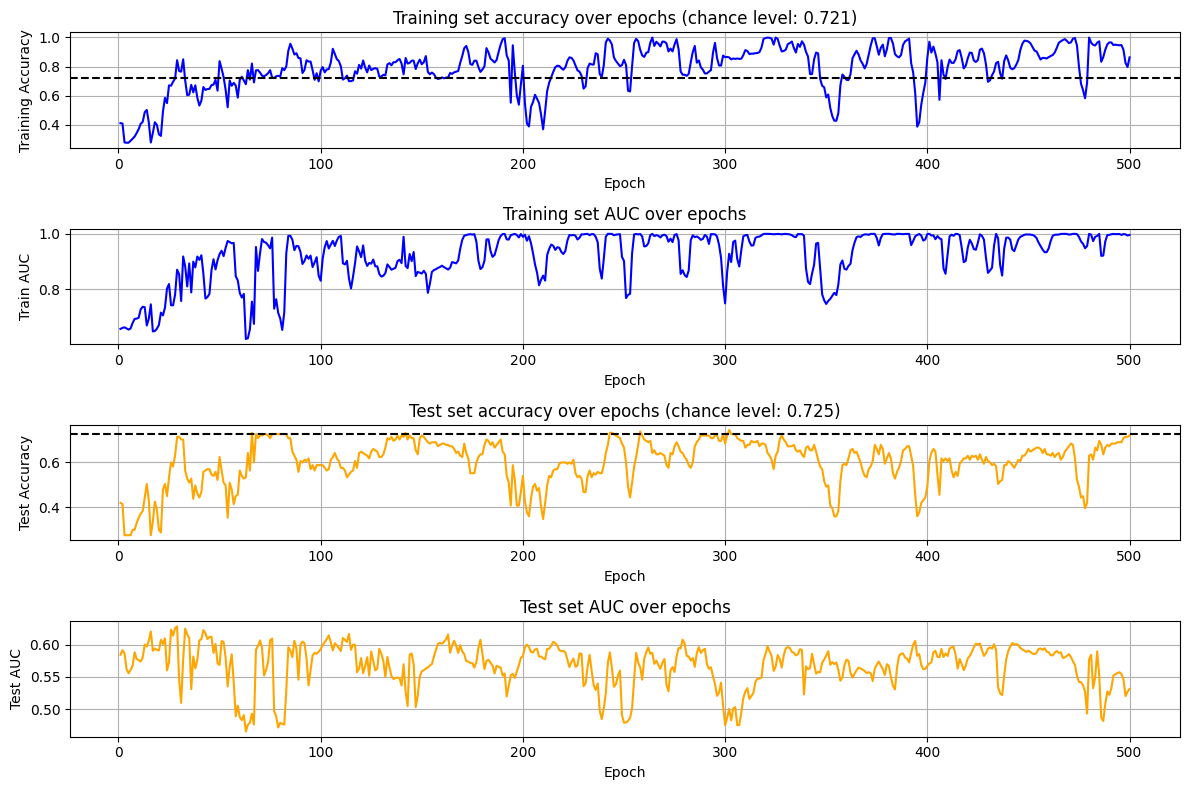

In [9]:
plot_functions.plot_model_history(
    model_history=train_history,
    report_frequency=initial_model.config.report_frequency,
    y_train=current_data.y_train,
    y_test=current_data.y_test,
    save_path=os.path.join(  # uncomment to save plot on disc
        data_directory, "initial_model_history.png"),
    data_save_path=os.path.join(
        data_directory, "initial_training_metrics.csv")
)

## Run binary PSO

Run pso algorithm to find features (genes) that lead the NN model to a better solution.

TO DO: is the algorithm leveraging the GPU??

In [ ]:
best_solution, best_fitness = pso.run_binary_pso(
    run_id=run_id,
    input_data=current_data,
    feature_names=current_genes,
    pop_size=200,
    # pop_size=3,
    n_generations=15,
    # n_generations=4,
    w=1,
    c1=2,
    c2=1.5,
    n_reps=4,
    # n_reps=1,
    verbose=True,
    # verbose=False,
    adaptive_metrics=False,
    output_prefix=data_directory,
)

19:58:52 [pso:456] No checkpoint found for run_id '250826_195727'. Starting fresh.
19:58:52 [pso:556] Starting PSO optimization with run_id: 250826_195727
19:58:52 [pso:222] ============================================================
19:58:52 [pso:223] Generation 1 started
19:59:03 [fitness_functions:134] Particle 1: Genes=850 | Mean AUC=0.645 | Time=11.51s
19:59:14 [fitness_functions:134] Particle 1: Genes=850 | Mean AUC=0.645 | Time=11.20s
19:59:26 [fitness_functions:134] Particle 1: Genes=850 | Mean AUC=0.645 | Time=11.23s
19:59:37 [fitness_functions:134] Particle 1: Genes=850 | Mean AUC=0.645 | Time=11.14s
19:59:48 [fitness_functions:134] Particle 2: Genes=852 | Mean AUC=0.649 | Time=11.63s
20:00:00 [fitness_functions:134] Particle 2: Genes=852 | Mean AUC=0.649 | Time=11.18s
20:00:11 [fitness_functions:134] Particle 2: Genes=852 | Mean AUC=0.649 | Time=11.20s
20:02:04 [fitness_functions:134] Particle 5: Genes=908 | Mean AUC=0.654 | Time=11.34s
20:02:15 [fitness_functions:134] Part

In [ ]:
# Load PSO results
loaded_fitness_scores = pd.read_pickle(
    os.path.join(data_directory, "pso_fitness_scores.pkl"))
loaded_particle_history = pd.read_pickle(
    os.path.join(data_directory, "pso_particle_history.pkl"))

In [ ]:
# Plot PSO results
plot_functions.plot_pso_fitness_evolution(
    fitness_history=loaded_fitness_scores,
    save_path=os.path.join(data_directory, "pso_fitness_evolution.png"))
plot_functions.plot_population_diversity(
    particle_history=loaded_particle_history,
    save_path=os.path.join(data_directory, "pso_population_diversity.png"))
plot_functions.plot_feature_selection_frequency(
    particle_history=loaded_particle_history,
    save_path=os.path.join(data_directory, "pso_feature_selection_frequency.png"))

## Initialize and train improved NN Model

In [ ]:
# the optimised solution is saved locally, however, the returned varible from
# the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open(os.path.join(data_directory, "pso_selected_genes.pkl"), "rb") as f:
    pso_genes = pickle.load(f)

In [ ]:
# now use this gene list to train a new model, which you can then evaluate
n_pso_input_features = len(pso_genes)

improved_model = AdvancedNN(
    n_input_features=n_pso_input_features,
    config=config,
)

# select feature subset and scale data
x_train, x_test, y_train, y_test = current_data.get_scaled_feature_subset(
    feature_subset=pso_genes
)

# Train model
improved_train_history = improved_model.train(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    **training_params,
)

In [ ]:
plot_functions.plot_model_history(
    model_history=improved_train_history,
    report_frequency=improved_model.config.report_frequency,
    y_train=y_train,
    y_test=y_test,
    save_path=os.path.join(  # uncomment to save plot on disc
        data_directory, "improved_model_history.png"),
    data_save_path=os.path.join(
        data_directory, "improved_training_metrics.csv")
)